Background: Dr. D wants to invest his profits in peer2peerlending (https://www.lendingclub.com/). He decides to invest $10,000,000.

Problem Statement: Propose and support with data an investment strategy for peer2peer lending.

Data Supplied: 30 million records from the site, from 2007 to 2018. Two files: accepted and rejected loans

Action items for notebook: all assumptions documented, Python code must be executable, upload any additional data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('accepted_2007_to_2018Q4.csv')

## Here we begin our data cleaning. We will remove missing columns missing more than 50% of their values from the original "data", and dropping any loans that are missing more than 10 values in any of the features. The dataframe Loans will only have loans that either defaulted or were fully paid, as having current loans are not useful for making models because their outcome is not known yet.

First, we create the "Data_Not_Current" set, which holds data for which the loan status is not Current, minus any missing rows and columns

In [3]:
data_missing_columns = data.columns[100*(data.isnull().sum()/len(data.index)) > 50]

Data_Not_Current = data.drop(data_missing_columns, axis=1)

Loans = Data_Not_Current.loc[(Data_Not_Current["loan_status"] == "Charged Off") | (Data_Not_Current["loan_status"] == "Default") | (Data_Not_Current["loan_status"] == "Fully Paid")]

Here we are cleaning Loans, which have some missing rows and columns removed

In [4]:
Loans_missing_columns = Loans.columns[100*(Loans.isnull().sum()/len(Loans.index)) > 50]
Loans = Loans.drop(Loans_missing_columns, axis=1)

Loans_missing_rows = Loans[Loans.isnull().sum(axis=1) > 10].index
Loans = Loans.drop(Loans_missing_rows, axis=0)

The value counts are printed out for the loan status, and in total the data set was reduced to around 1.25 million loans

In [5]:
Loans['loan_status'].value_counts()

Fully Paid     1019542
Charged Off     258241
Default             40
Name: loan_status, dtype: int64

### The following variables are either not available before a loan was given out, or had little to no effect on the models used later.

In [6]:
variables_to_drop = ["debt_settlement_flag","last_pymnt_amnt","recoveries", "collection_recovery_fee", "issue_d", "addr_state", "earliest_cr_line", "zip_code", "last_credit_pull_d","emp_title","hardship_flag","policy_code","pymnt_plan","id","url", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "tot_coll_amt", "tot_cur_bal", "avg_cur_bal","last_pymnt_d"]
Loans = Loans.drop(variables_to_drop,axis=1)
variables_to_drop2=["grade", "sub_grade","emp_length", "funded_amnt", "funded_amnt_inv", "fico_range_high", "fico_range_low"]
Loans = Loans.drop(variables_to_drop2,axis=1)
counts = Loans['loan_status'].value_counts()
default_rate = (counts[1]+counts[2])/(counts[0]+counts[1]+counts[2])

print("Notice that the default rate is", round(default_rate*100, 4), "%.")

Notice that the default rate is 20.2126 %.


After exploring the data, it was found that there were a couple ten thousand different options for the title feature. This causes an issue when trying to one hot encode the variables, so to combat this, the top four titles were found which are stored in the preserved variable, and the rest were changed to other. 

In [7]:
Loans['title'].value_counts()
preserved = ['Debt consolidation','Credit card refinancing','Home improvement','Major purchase']

Here term was changed to as a whole to be an int so it is machine readable, and a couple of other variables that only had two options were changed to 0 and 1 instead of the previous labels they had so they could be used in regression.

In [8]:
Loans.loc[~Loans['title'].isin(preserved), 'title'] = 'Other'
Loans['term'] = Loans.term.str.replace(' months','').astype(int)
Loans['disbursement_method'] = Loans['loan_status'].apply(lambda x: 0 if x=='DirectPay' else 1)
Loans['application_type'] = Loans['application_type'].apply(lambda x: 0 if x=='Individual' else 1)
Loans['initial_list_status'] = Loans['initial_list_status'].apply(lambda x: 0 if x=='w' else 1)

Here is the calculation for what would be the expected profit of the loan, which is the interest of the loan, assumming it is payed in full

In [9]:
Loans['expected_profit'] = (Loans['installment'] *  (Loans['term']) - Loans['loan_amnt'])
Loans.head()

,loan_amnt,term,int_rate,installment,home_ownership,annual_inc,verification_status,loan_status,purpose,title,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,expected_profit
0,3600.0,36,13.99,123.03,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,Debt consolidation,...,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,1,829.08
1,24700.0,36,11.99,820.28,MORTGAGE,65000.0,Not Verified,Fully Paid,small_business,Other,...,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,1,4830.08
2,20000.0,60,10.78,432.66,MORTGAGE,63000.0,Not Verified,Fully Paid,home_improvement,Other,...,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,1,5959.60
4,10400.0,60,22.45,289.91,MORTGAGE,104433.0,Source Verified,Fully Paid,major_purchase,Major purchase,...,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,1,6994.60
5,11950.0,36,13.44,405.18,RENT,34000.0,Source Verified,Fully Paid,debt_consolidation,Debt consolidation,...,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,1,2636.48


While some features were removed because they were missing a lot of data, there is still a lot of missing data in the dataframe, which will cause issues later when the data is used in the Random Forest and other models. An imputer is used to fill in the values, with the numeric features replacing any missing values with the median, and the categorical features having missing data be replaced with a designation of Other. Imputing allows the data to be used later, because otherwise there would issues with the Random Forest, Adaptive Boost, and the Gradient Boosted Tree which will be seen later.

In [10]:
from sklearn.impute import SimpleImputer
target = 'loan_status'
numeric_features = Loans.select_dtypes(include=['int64', 'float64']).columns
tmp_annual_inc = Loans['annual_inc']
categorical_features = Loans.select_dtypes(include=['object', 'category']).drop([target], axis=1).columns
for col in categorical_features.tolist():
        Loans[col] = Loans[col].astype('category')
Loans[target] = Loans[target].astype('category')

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(Loans[numeric_features.tolist()])
Loans[numeric_features.tolist()] = imputer.transform(Loans[numeric_features.tolist()])

imputercat = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value='Missing')
Loans[categorical_features] = imputercat.fit_transform(Loans[categorical_features.tolist()])

Here is one feature that was added and it is looking at the installment payed monthly over the annual income. There were a lot of values in the annual income column that were 0, which could either mean that that person did not input the income, or that their income is actually 0. To combat that value from being infinity, one was added to the annual income, and while it may technically make the feature innaccurate, the point of adding it is to try and help some of the models with accuracy. Other feature were added as well, but there was no real significant difference in any of the accuracies, so none were kept in the final product.

In [11]:
Loans['installment/ monthly income'] = (Loans['installment']/(1+(Loans['annual_inc']/12)))

Here a random sample is taken from the cleaned dataframe. This is to increase the speed of the Random Forest and other models. There were attempts with the full dataframe, and other larger sample sizes, but the difference in accuracy was negligible, if at all increased, and it allows for more of the variables to be kept.

In [12]:
Loans_Sample = Loans.sample(75000)

Now we have to split the data into test and train dataframes in order for it to be used in the models. The X dataframe has all of the feature variables, while the y dataframe only has the target variables. In the X dataframe, all of the categorical variables were one hot encoded so that they were machine readable. Lastly, the response variable was recoded to have the Fully Paid Variables be assigned to 1, and the Defaulting Loans be set to 0.

In [13]:
X = Loans_Sample.loc[:, Loans.columns != target]
y = Loans_Sample[target]
X = pd.get_dummies(X)
repmap={"Fully Paid": 1, "Default": 0, "Charged Off":0}
y.replace(repmap, inplace=True)

The following functions are for graphing and were provided in the class python notebooks showing the accuracies, precision, f1 score, and other metrics for each of the models.

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

def viz_conf_mat(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  con_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_df = pd.DataFrame(con_matrix, ('Default', 'Paid'), ('Default', 'Paid'))
  heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
  plt.ylabel('Actual', fontsize = 14)
  plt.xlabel('Predicted', fontsize = 14)
    
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

def baseline_AUC(y_test):
    ones = [1 for _ in y_test]
    fpr, tpr, _ = roc_curve(y_test, ones)
    results = {'fpr': fpr, 'tpr': tpr,
      'accuracy': accuracy_score(y_test, ones),
      'recall': recall_score(y_test, ones),
      'precision': precision_score(y_test, ones),
      'roc AUC': 0.5}
    return {'Baseline' : results}

def model_AUC(AUC, y_pred, y_test, probs, label):
    """Computes statistics and shows ROC curve compared to prior methods."""
    fpr, tpr, _ = roc_curve(y_test, probs)
    AUC[label] = {'fpr': fpr, 'tpr': tpr,
      'accuracy': accuracy_score(y_test, y_pred),
      'recall': recall_score(y_test, y_pred),
      'precision': precision_score(y_test, y_pred),
      'roc AUC': roc_auc_score(y_test, probs) }
    return AUC

def plot_AUC(AUC):
    metrics = ['accuracy', 'recall', 'precision', 'roc AUC']
    print(' '*20, end ='')
    for m in metrics:
      print(f'{m.capitalize():>10}', end = '')
    print()
    for label, results in AUC.items():
        print(f'{label:>18}:', end = '')
        for m in metrics:
          print(f'{results[m]:10.2f}', end = '')
        print()
    
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    for label, results in AUC.items():
      plt.plot(results['fpr'], results['tpr'], label = label)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show()
def plot_importances(model, X_test, y_test, mycolumns):
    importances = pd.Series(model.feature_importances_, index = mycolumns)
    permImp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_importances = importances.sort_values()
    sorted_importances = sorted_importances[-15:]
    sorted_idx = permImp.importances_mean.argsort()
    sorted_idx = sorted_idx[-15:]


    plt.figure(figsize=(35,15))
    plt.subplot(1, 2, 1)
    sorted_importances.plot(kind='barh', color='skyblue');
    plt.title("Feature Importance (train set)") 

    plt.subplot(1, 2, 2)
    plt.boxplot(
        permImp.importances[sorted_idx].T,
        vert=False, 
        labels=np.array(mycolumns)[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    plt.show()
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

def fit_evaluate(model, X_train, y_train, X_test, y_test, 
                 label='', AUC=dict(), mycolumns=X.columns,
                 show_confusion=True, show_Imp=True):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
   
  if (show_confusion):
     viz_conf_mat(y_test, y_pred)
  
  if (len(AUC) > 0): 
    AUC = model_AUC(AUC, y_pred, y_test, model.predict_proba(X_test)[:, 1], label)
    plot_AUC(AUC)

  if (show_Imp):
    plot_importances(model, X_test, y_test, mycolumns)

  return AUC

The first model used was the Gradient Boosting Classifier. Some of the hyperparameters were adjusted, but there was no major difference in any of the changes as well. Overall the AUC for this model was usually around 95%, while the F1 score for the defaults was around .77-.80. The other important thing to note is that this model used both of the FICO score ranges as the most important feature. As it will be seen later, this is a common theme between each of the models.

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      4538
           1       0.95      0.93      0.94     17962

    accuracy                           0.91     22500
   macro avg       0.85      0.87      0.86     22500
weighted avg       0.91      0.91      0.91     22500

                      Accuracy    Recall Precision   Roc auc
          Baseline:      0.80      1.00      0.80      0.50
               GBT:      0.91      0.93      0.95      0.95


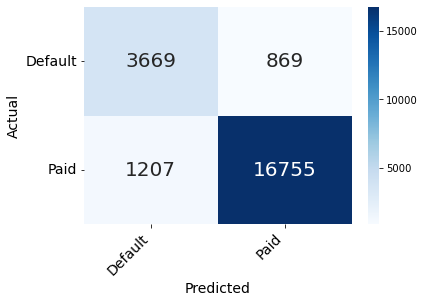

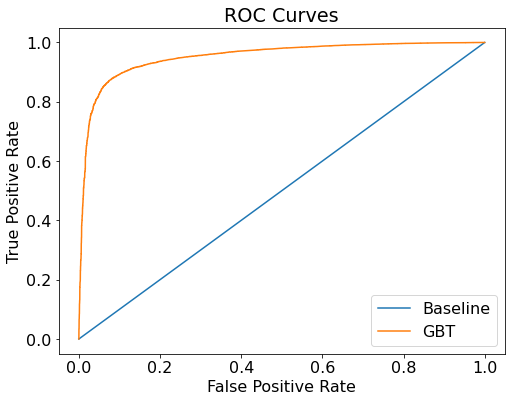

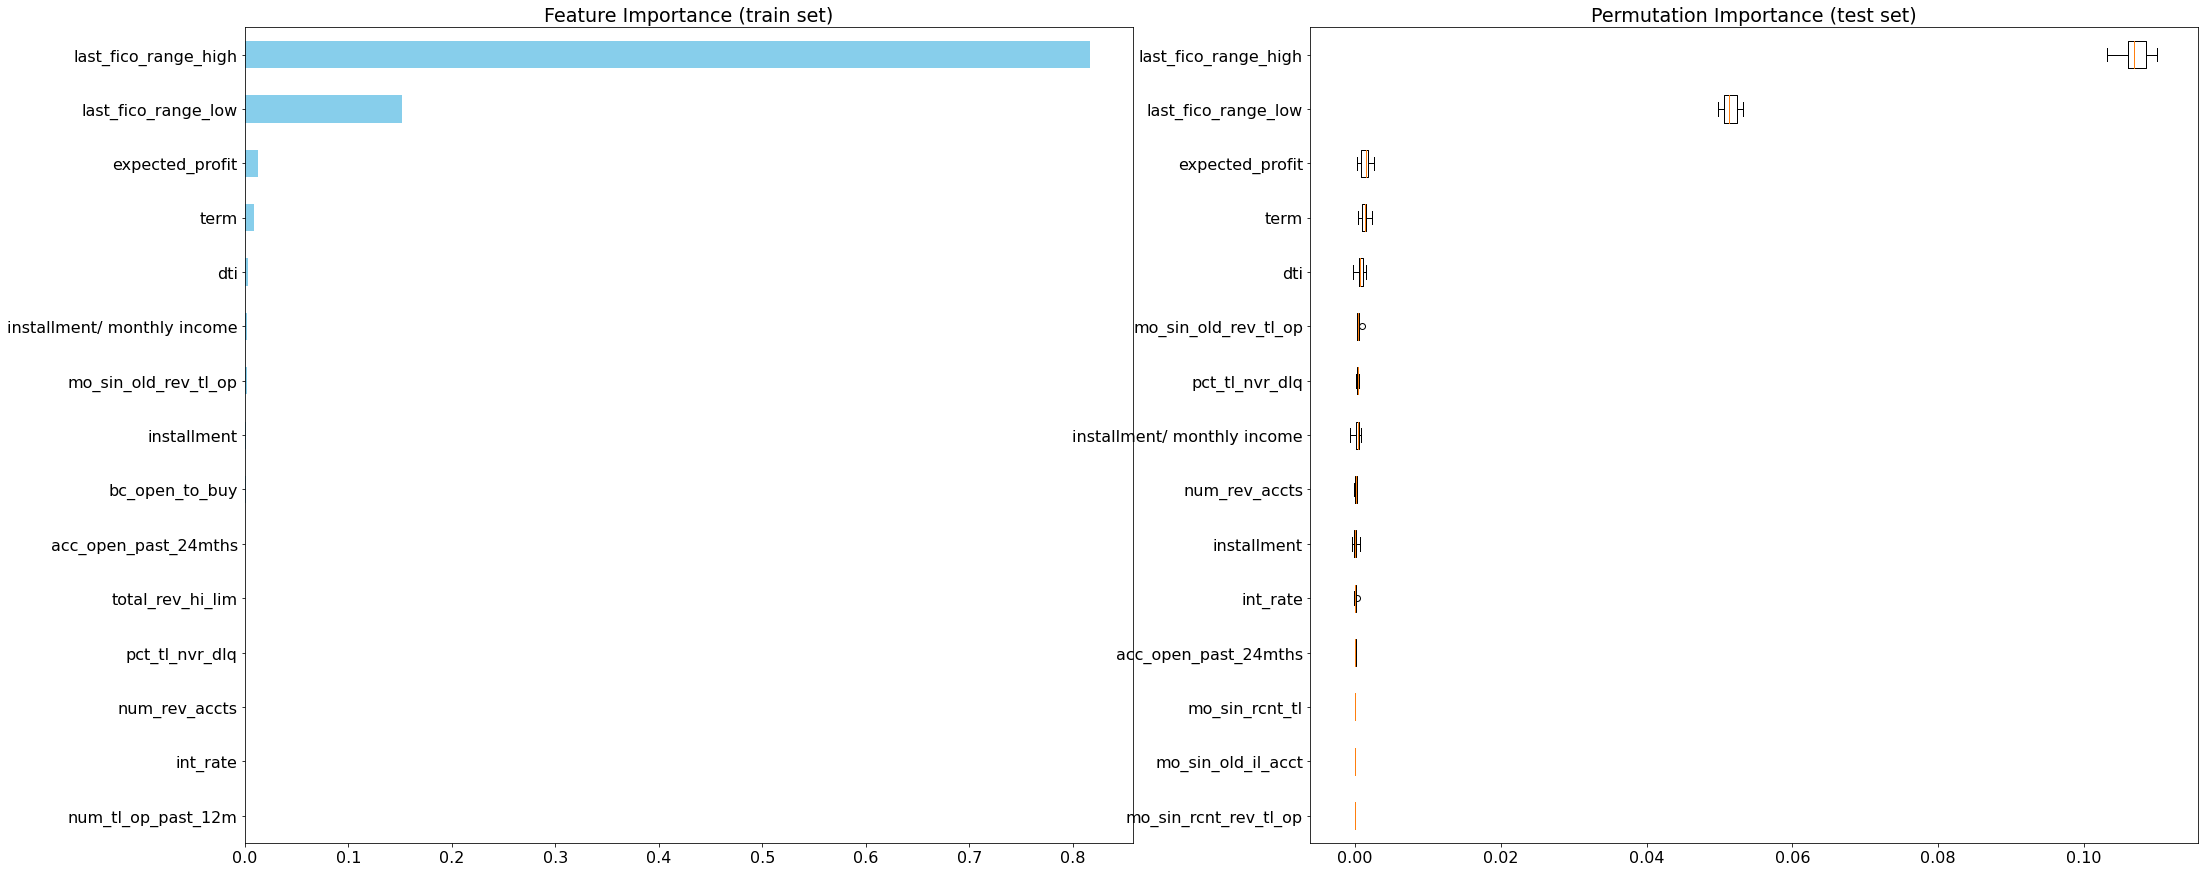

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE


# Split data into 70% train and 30% test, stratified by target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

# Instantiate a GradientBoostingRegressor 'gbt'
gbt = GradientBoostingClassifier(n_estimators=150, max_depth=1, random_state=42)

gbt.fit(X_train, y_train)

y_pred = gbt.predict(X_test)

GB_RMSE = MSE(y_test, y_pred)**(1/2)

fit_evaluate(gbt, X_test, y_test,X_test, y_test, 
                       label='GBT', AUC = baseline_AUC(y_test));

I am pretty sure this can just be deleted, but I will keep it as Markdown for now just to be safe until the entire thing is ran again

The next model is the Random Forest. The accuracies and F1 scores are pretty similar to the GBT, and it also generally had an AUC of around 95%. The important thing to note once again is that the most important features were the FICO score ranges.

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      4538
           1       0.94      0.94      0.94     17962

    accuracy                           0.91     22500
   macro avg       0.85      0.85      0.85     22500
weighted avg       0.91      0.91      0.91     22500

                      Accuracy    Recall Precision   Roc auc
          Baseline:      0.80      1.00      0.80      0.50
     Random Forest:      0.91      0.94      0.94      0.94


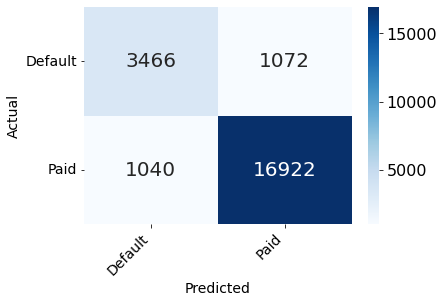

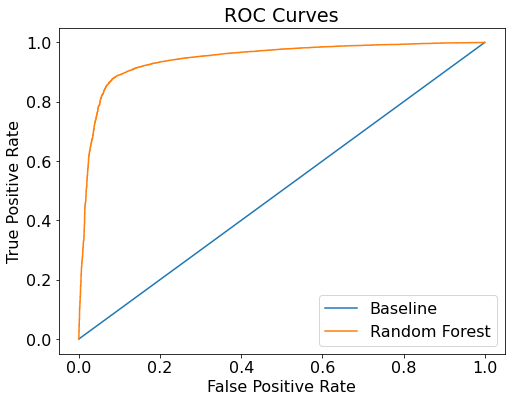

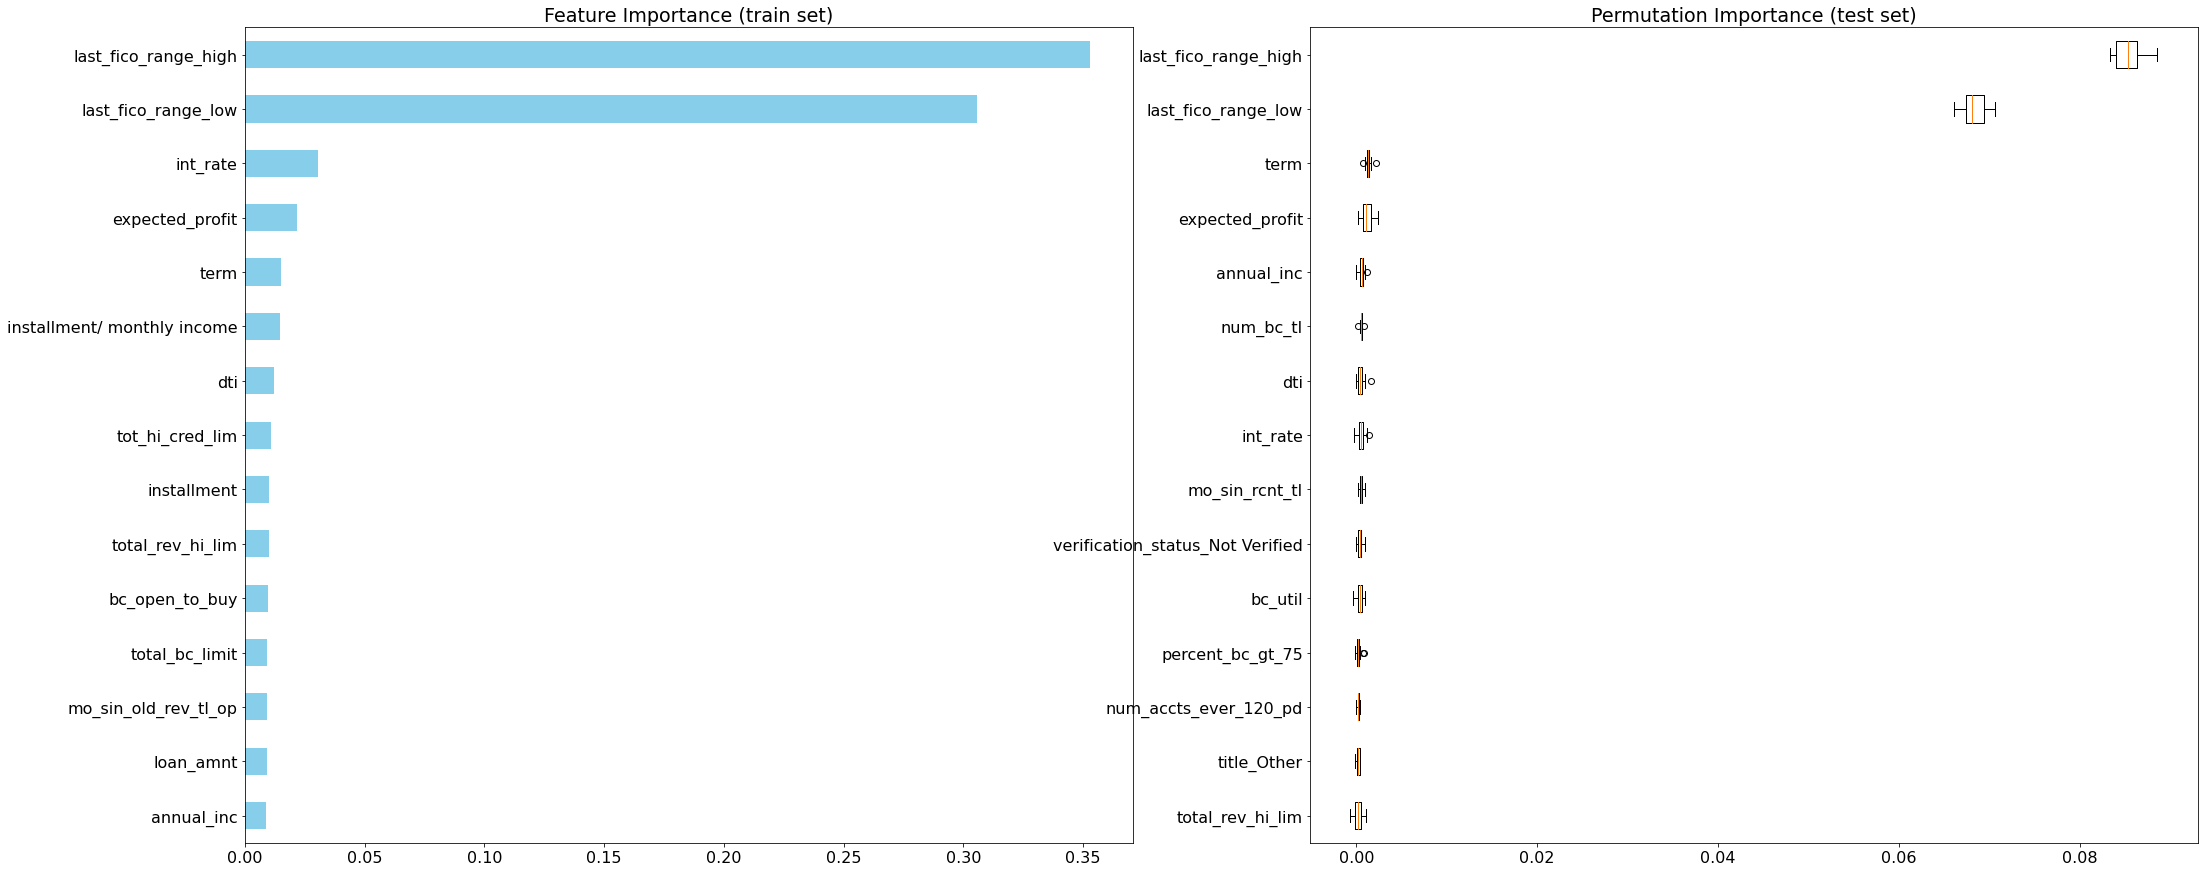

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE


# Split data into 70% train and 30% test, stratified by target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, bootstrap = True, max_features = 'auto', 
                            min_samples_leaf = 5, criterion='gini', random_state=42, max_depth=15)

results = fit_evaluate(rf, X_train, y_train, X_test, y_test, 
                       label='Random Forest', AUC = baseline_AUC(y_test));

The last model that was used was the Adaptive Boost. This usually had a lower F1 score compared to the other two, but did have an AUC of around 95%. It once again had the FICO score ranges consistently being the most important feature that it used.

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      4538
           1       0.94      0.93      0.94     17962

    accuracy                           0.90     22500
   macro avg       0.85      0.86      0.85     22500
weighted avg       0.90      0.90      0.90     22500

                      Accuracy    Recall Precision   Roc auc
          Baseline:      0.80      1.00      0.80      0.50
     Random Forest:      0.91      0.94      0.94      0.94
          AdaBoost:      0.90      0.93      0.94      0.95


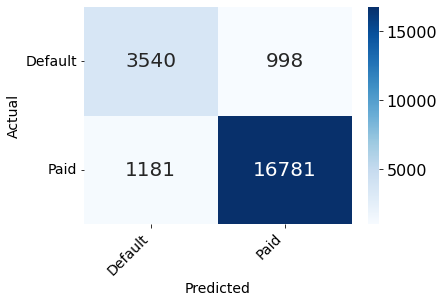

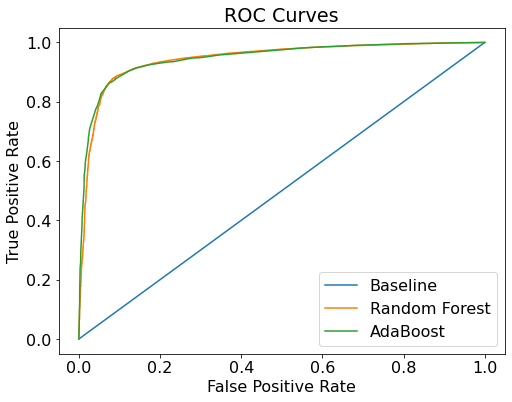

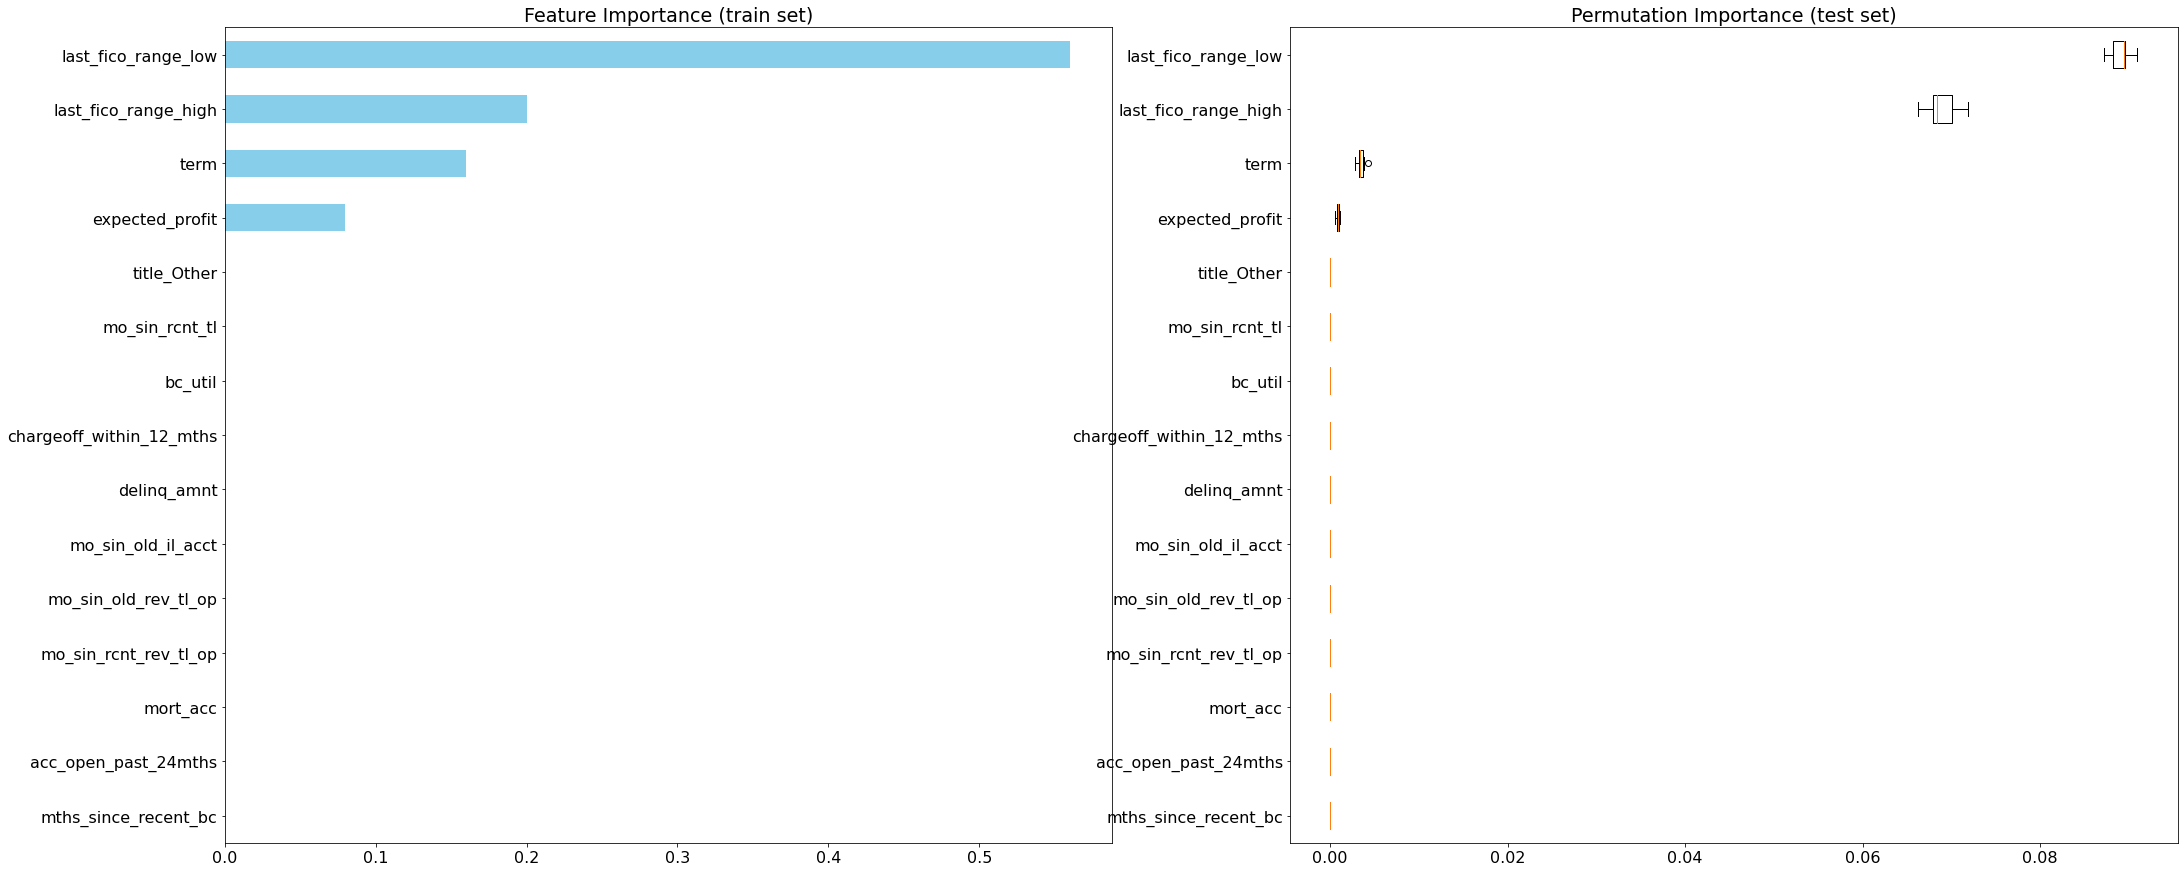

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

idiot = DecisionTreeClassifier(max_depth=1, criterion='gini', min_samples_leaf = 5, splitter = "random")

adb_clf = AdaBoostClassifier(base_estimator=idiot, n_estimators=25, learning_rate=.2, random_state=42)

results = fit_evaluate(adb_clf, X_train, y_train, X_test, y_test, label='AdaBoost', AUC = results)

The Random Forest was used as a classifier, but the probabilities that it used for a loan being payed or not can be extracted. These probabilities were extracted and put into a DataFrame to be used later, with a probability of 1 being that the Random Forest thinks the loan is absolutely going to be payed, and a probability of 0 being the Random Forest thinking that the loan will absolutely not be paid and default.

In [18]:
y_pred = rf.predict(X_test)
probs = rf.predict_proba(X_test)[:, 1]
results2= pd.DataFrame({'classes':y_pred, 'probabilities':probs})

These probabilities were placed into a copy of the Test data, where it was then used to calculate the expected loss. This was calculated by doing 1 minus the calculated probability of the loan by the total amount of the loan. The expected loss was then subtracted from the previously calculated expected profit of the loan, which is the interest that would be payed if the loan was payed in full, which gave a new value which may be positive or negative. It was also assumed here that a defaulting loan would mean everything is lost from the loan amount given out.

In [19]:
tmp = X_test.copy()
tmp['Prob of Paying Loan'] = results2['probabilities'].values

In [20]:
tmp['expected_loss'] = (1-tmp['Prob of Paying Loan'])*tmp['loan_amnt'] 

In [21]:
tmp['EP - EL'] = tmp['expected_profit'] - tmp['expected_loss']

With the newly calculated value from above, below multiple different method were used and the total profits were recorded, which was the 'EP - EL' column from above summed. The first method was just the top 100 values with the 'EP - EL' column sorted, and this was used to see what was the max profit that could be achieved in this example. The other methods included a random sample, sorting by the top expected profits, the top fico scores, highest interest rates and lowest interest rates.

In [22]:
def calc_amnt(pm):
    return np.sum(pm['loan_amnt'])

In [23]:
our_method = tmp.sort_values('EP - EL', ascending=False).head(100)
our_method_value = calc_amnt(our_method)

In [24]:
random_method = tmp.sample(100)
random_method_value = calc_amnt(random_method)

In [25]:
top_ep = tmp.sort_values('expected_profit', ascending=False).head(100)
top_ep_value = calc_amnt(top_ep)

In [26]:
fico_score = tmp.sort_values('last_fico_range_high', ascending=False).head(100)
fico_score_value = calc_amnt(fico_score)

In [27]:
int_rate_high = tmp.sort_values('int_rate', ascending=False).head(100)
int_rate_high_value = calc_amnt(int_rate_high)

In [28]:
int_rate_low = tmp.sort_values('int_rate', ascending=True).head(100)
int_rate_low_value = calc_amnt(int_rate_low)

Because the amount of money given may have been different in each of the methods, the ROI was calculated instead of net profit so they could be more accurately compared.

In [29]:
our_method_profit = 100*(np.sum(our_method['EP - EL']) / our_method_value)
random_method_profit = 100*(np.sum(random_method['EP - EL']) / random_method_value)
top_ep_profit = 100*(np.sum(top_ep['EP - EL']) / top_ep_value)
fico_score_profit = 100*(np.sum(fico_score['EP - EL']) / fico_score_value)
int_rate_high_profit = 100*(np.sum(int_rate_high['EP - EL']) / int_rate_high_value)
int_rate_low_profit = 100*(np.sum(int_rate_low['EP - EL']) / int_rate_high_value)
d = {'Method': ["Our Method", "Random Method", "Top Expected Profit", "Top Fico Scores", "Highest Interest Rates", "Lowest Interest Rates"], 'ROI %': [our_method_profit, random_method_profit, top_ep_profit, fico_score_profit,int_rate_high_profit,int_rate_low_profit]}
tab = pd.DataFrame(data=d, index=[0,1,2,3,4,5])

In [30]:
sns.set(rc={'figure.figsize':(14,14)})

The barplot below shows the ROIs for each of the calculated methods. Because these values are based off of the probabilities from the Random Forest, which was not perfectly accurate, the real Return on Investmet from each of these methods may not be correct. What is important is the looking at what features seem to be doing better. The highest interest rates, and the top expected profit if a loan is payed in full seem to be pretty similar with the random sample and Top FICO scores doing a little worse. To see if there was a bias from the Random Sample, these features are going to be tested in a simualtion.

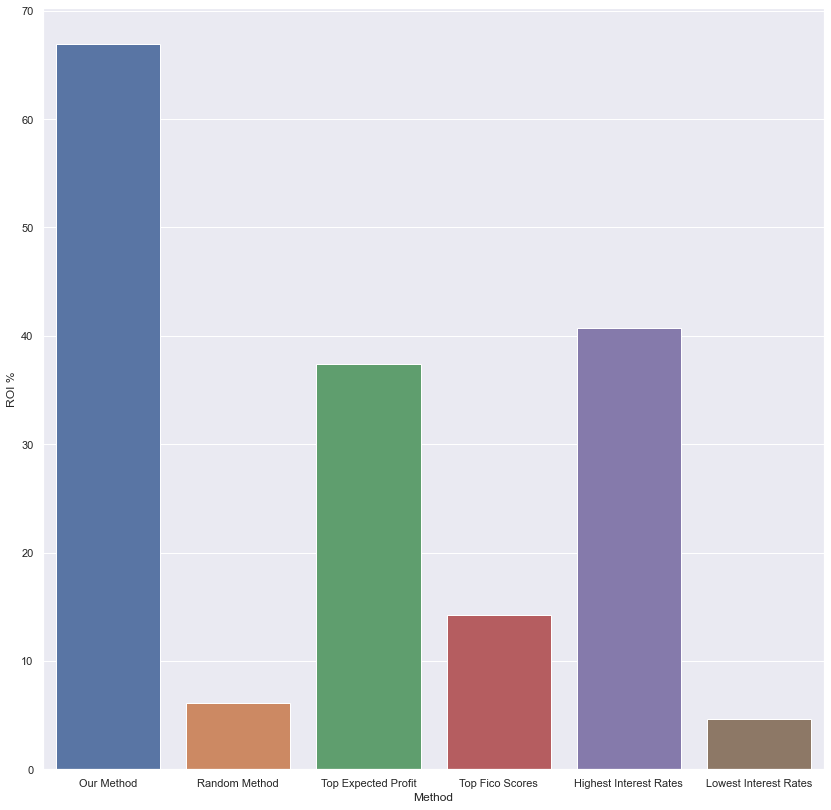

In [31]:
sns.barplot(x='Method', y='ROI %', data=tab);

Remembering the percentage of loans that actually defaulting from before, which was around 20%, the goal here to to make a dataframe with a much higher rate of defaulting loans, in order to make it harder to make money. This is accomplished by taking all of the defaulting loans and combining it with a small sample of the loans that were paid in full. The split here is roughly 85% deafulting loans, and roughly 15% loans that are actually going to be paid. This makes it much harder to actually have a positive return, because there are a lot more defaulting loans. While it is possible for a defaulting loan to give the lender a profit, in this simulation all of the loans that defaulted will be a loss of money.

In [32]:
Loans['loan_status'].value_counts()

Fully Paid     1019542
Charged Off     258241
Default             40
Name: loan_status, dtype: int64

In [33]:
Defs = Loans.loc[(Loans["loan_status"] == "Charged Off") | (Loans["loan_status"] == "Default")]

In [34]:
Paid_Loans = Loans.loc[(Loans["loan_status"] == "Fully Paid")]

In [35]:
Paid_Loans.shape

(1019542, 64)

In [36]:
Paid_Loans = Paid_Loans.sample(42000)

In [37]:
frames = [Paid_Loans, Defs]
Bad_Sample = pd.concat(frames)

In [38]:
Bad_Sample['loan_status'].value_counts()

Charged Off    258241
Fully Paid      42000
Default            40
Name: loan_status, dtype: int64

In [39]:
Bad_Sample['Simulated Profit Var'] = Bad_Sample['loan_status'].apply(lambda x: 1 if x=='Fully Paid' else -1)

In [40]:
Bad_Sample['Simulated Profit'] = 0

In [41]:
Bad_Sample.head()

,loan_amnt,term,int_rate,installment,home_ownership,annual_inc,verification_status,loan_status,purpose,title,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,expected_profit,installment/ monthly income,Simulated Profit Var,Simulated Profit
681511,23175.0,60,19.99,613.87,MORTGAGE,48000.0,Not Verified,Fully Paid,debt_consolidation,Debt consolidation,...,0.0,291752.0,54702.0,4900.0,45542.0,1.0,13657.20,0.153429,1,0
1784283,35000.0,60,20.20,931.19,MORTGAGE,133066.0,Source Verified,Fully Paid,debt_consolidation,Other,...,0.0,442000.0,125961.0,7700.0,113600.0,1.0,20871.40,0.083968,1,0
193723,5000.0,36,15.61,174.83,MORTGAGE,76000.0,Not Verified,Fully Paid,debt_consolidation,Debt consolidation,...,0.0,304270.0,35843.0,3000.0,44970.0,1.0,1293.88,0.027600,1,0
291670,15000.0,36,7.89,469.29,MORTGAGE,89000.0,Not Verified,Fully Paid,credit_card,Credit card refinancing,...,0.0,33300.0,14627.0,16100.0,0.0,1.0,1894.44,0.063267,1,0
1280486,30000.0,36,7.90,938.71,RENT,108229.0,Verified,Fully Paid,debt_consolidation,Debt consolidation,...,0.0,100652.0,71971.0,19100.0,60656.0,1.0,3793.56,0.104069,1,0


Here is the calculation to find what percentage of the loan someone paid on average before the person defaulted. The calcualted value was around 54%, and this will be used to calculate how much money is lost from a loan that defaulting.

In [42]:
test2 = data.loc[(data["loan_status"] == "Charged Off") | (data["loan_status"] == "Default")]

In [43]:
test2['% payed'] = test2['total_pymnt'] / test2['loan_amnt']

In [44]:
avg_payed_from_default = (1-np.mean(test2['% payed']))

Here the simulated profit will be calculated, with a loan that is fully paid being the interest on a loan, and a defaulting loan being the calculated average payment left for a defaulted loan times the loan amount and times negative one to represent a loss.

In [45]:
for i in range(300281):
    if (Bad_Sample['Simulated Profit Var'].iloc[i] == 1):
        Bad_Sample['Simulated Profit'].iloc[i] = Bad_Sample['expected_profit'].iloc[i]
    else:
        Bad_Sample['Simulated Profit'].iloc[i] = (Bad_Sample['loan_amnt'].iloc[i] * -1)*avg_payed_from_default

In [46]:
def calc_profit(sam):
    return np.sum(sam['Simulated Profit'])

In [47]:
def calc_amnt_sim(sam):
    return np.sum(sam['loan_amnt'])

Similar to the methods create above, these methods are based off of the features that were seen, but retested in this dataframe where a loan is much more likely to default. The methods include a random sample, highest FICO score, lowest FICO score, highest interest rates, and highest expected profit. The return on investment was also calculated instead of net profit to account for differences in total loan amount given out from each of the methods.

In [48]:
random_method = Bad_Sample.sample(250)
random_method_value = calc_profit(random_method)

In [49]:
FICO_method = Bad_Sample.sort_values('last_fico_range_high', ascending=False).head(250)
FICO_method_value = calc_profit(FICO_method)

In [50]:
FICO_low_method = Bad_Sample.sort_values('last_fico_range_high', ascending=True).head(250)
FICO_low_method_value = calc_profit(FICO_low_method)

In [51]:
int_rate_high_method2 = Bad_Sample.sort_values('int_rate', ascending=False).head(250)
int_rate_high_value = calc_profit(int_rate_high_method2)

In [52]:
expected_profit_method2 = Bad_Sample.sort_values('expected_profit', ascending=False).head(250)
expected_profit_high_value = calc_profit(expected_profit_method2)

In [53]:
random_profit = 100*(random_method_value / calc_amnt_sim(random_method))
high_FICO_profit = 100*(FICO_method_value / calc_amnt_sim(FICO_method))
low_FICO_profit = 100*(FICO_low_method_value / calc_amnt_sim(FICO_low_method))
int_rate_high_profit = 100*(int_rate_high_value / calc_amnt_sim(int_rate_high_method2))
expected_profit_profit = 100*(expected_profit_high_value / calc_amnt_sim(expected_profit_method2))

d = {'Method': ["Random Method","Highest FICO Scores","Lowest FICO Scores", "top interest rates", "top expected profit"], 'ROI %': [random_profit, high_FICO_profit, low_FICO_profit, int_rate_high_profit, expected_profit_profit]}
tabs = pd.DataFrame(data=d, index=[0,1,2,3,4])

In [54]:
sns.set(rc={'figure.figsize':(14,14)})

After plotting the methods, there is a glaring outlier out of the 5, with it being the highest FICO scores. All of the other method recorded big losses, which is not that unexpected knowing that 85% of these loans were expected to default and thus lose money in this simulation. The one outlier was the highest FICO scores, which was still able to have a positive return on investment, even with the increased defaulting loans.

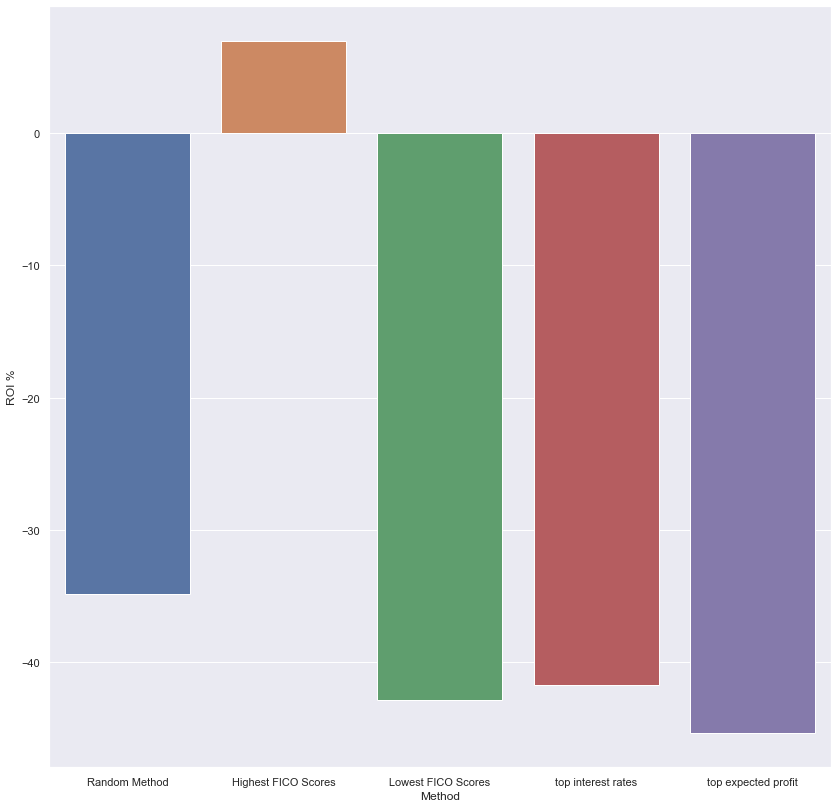

In [55]:
sns.barplot(x='Method', y='ROI %', data=tabs);

Because one trial could have some variability in the actually values, a function was created in order to run the simulation multiple times, but this time instead of 85% defaulting loans, it was increased to 90%, and there will be samples taken from both the defaulting loans and paid loans to make each dataframe.

In [145]:
def simulation():
    Defs = Loans.loc[(Loans["loan_status"] == "Charged Off") | (Loans["loan_status"] == "Default")]
    #print(np.mean(Defs['last_fico_range_high'])) this was used to find the average FICO score for the default loans 567
    Defs = Defs.sample(4500)
    Paid_Loans = Loans.loc[(Loans["loan_status"] == "Fully Paid")]
    #print(np.mean(Paid_Loans['last_fico_range_high'])) this was used to find the average FICO score for the paid loans which was 704
    Paid_Loans = Paid_Loans.sample(500)
    frames = [Paid_Loans, Defs]
    Bad_Sample = pd.concat(frames)
    avg_FICO = np.mean(Bad_Sample['last_fico_range_high'])
    Bad_Sample['Simulated Profit Var'] = Bad_Sample['loan_status'].apply(lambda x: 1 if x=='Fully Paid' else -1)
    Bad_Sample['Simulated Profit'] = 0
    for i in range(5000):
        if (Bad_Sample['Simulated Profit Var'].iloc[i] == 1):
            Bad_Sample['Simulated Profit'].iloc[i] = Bad_Sample['expected_profit'].iloc[i]
        else:
            Bad_Sample['Simulated Profit'].iloc[i] = (Bad_Sample['loan_amnt'].iloc[i] * -1)*avg_payed_from_default
    random_method = Bad_Sample.sample(250)
    random_method_value = calc_profit(random_method)
    FICO_method = Bad_Sample.sort_values('last_fico_range_high', ascending=False).head(250)
    avg_FICO_from_top = np.mean(FICO_method['last_fico_range_high'])
    FICO_method_value = calc_profit(FICO_method)
    FICO_low_method = Bad_Sample.sort_values('last_fico_range_high', ascending=True).head(250)
    FICO_low_method_value = calc_profit(FICO_low_method)
    int_rate_high_method2 = Bad_Sample.sort_values('int_rate', ascending=False).head(250)
    int_rate_high_value = calc_profit(int_rate_high_method2)
    expected_profit_method2 = Bad_Sample.sort_values('expected_profit', ascending=False).head(250)
    expected_profit_high_value = calc_profit(expected_profit_method2)
    random_profit = 100*(random_method_value / calc_amnt_sim(random_method))
    high_FICO_profit = 100*(FICO_method_value / calc_amnt_sim(FICO_method))
    low_FICO_profit = 100*(FICO_low_method_value / calc_amnt_sim(FICO_low_method))
    int_rate_high_profit = 100*(int_rate_high_value / calc_amnt_sim(int_rate_high_method2))
    expected_profit_profit = 100*(expected_profit_high_value / calc_amnt_sim(expected_profit_method2))
    return random_profit, high_FICO_profit, low_FICO_profit, int_rate_high_profit, expected_profit_profit, avg_FICO_from_top, avg_FICO
    

In [129]:
rp = []
hf = []
lf = []
irh = []
ep = []
fs = []
ft = []

In [130]:
for i in range(1000):
    rp1, hf1, lf1, irh1, ep1, fs1, ft1 = simulation()
    rp.append(rp1)
    hf.append(hf1)
    lf.append(lf1)
    irh.append(irh1)
    ep.append(ep1)
    fs.append(fs1)
    ft.append(ft1)

In [134]:
rp_mean = np.mean(rp)
hf_mean = np.mean(hf)
lf_mean = np.mean(lf)
irh_mean = np.mean(irh)
ep_mean = np.mean(ep)

fs_mean = np.mean(fs)
ft_mean = np.mean(ft)

In [139]:
da = {'Method': ["Random Method","Highest FICO Scores","Lowest FICO Scores", "top interest rates", "top expected profit"], 'Average ROI % over 1000 Trials': [rp_mean, hf_mean, lf_mean, irh_mean, ep_mean]}
tabs = pd.DataFrame(data=da, index=[0,1,2,3,4])

In [136]:
sns.set(rc={'figure.figsize':(14,14)})

Similar to original trial, the Highest FICO scores method is the only method that was able to have a positive return with major losses in all of the other methods. This shows that the original trial was not an outlier due to sampling, and the difference going with the highest FICO scores is statistically significant.

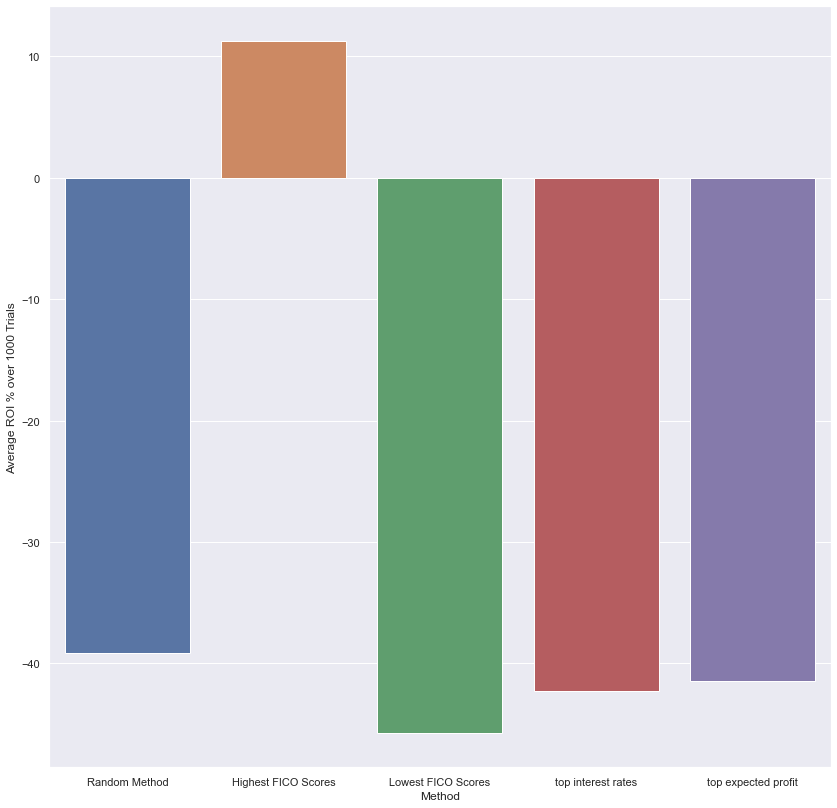

In [140]:
sns.barplot(x='Method', y='Average ROI % over 1000 Trials', data=tabs);

In [147]:
print("Average FICO score of the all of the Highest FICO score methods was " + str(fs_mean))
print("Average FICO score of the total simulation dataset was " + str(ft_mean))

Average FICO score of the all of the Highest FICO score methods was 757.3018159999999
Average FICO score of the total simulation dataset was 580.8890454


As a result from these findings, the investment method that should be followed is to look for the highest FICO scores abailable when giving out loans. In the total dataset, the average FICO score from Fully Paid loans was roughly 704, compared to 567 from the defaulting loans. Targeting high FICO scores, especially those above 750, is a viable investment strategy that can help to both minimize risk, and have potential for modest profit.